In [2]:
!pip install mlxtend

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
df_retail = pd.read_csv('/content/online_retail_II.csv', encoding='ISO-8859-1')

print(df_retail.head())

  ï»¿Invoice StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  Price  Customer ID         Country  
0  12/1/2010 8:26   2.55      17850.0  United Kingdom  
1  12/1/2010 8:26   3.39      17850.0  United Kingdom  
2  12/1/2010 8:26   2.75      17850.0  United Kingdom  
3  12/1/2010 8:26   3.39      17850.0  United Kingdom  
4  12/1/2010 8:26   3.39      17850.0  United Kingdom  


# **Cleaning**

In [18]:
print(df_retail.isnull().sum())

ï»¿Invoice          0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


In [144]:
df_retail.dropna(subset=['Customer ID'], inplace=True)

In [145]:
df_retail.rename(columns={'ï»¿Invoice': 'InvoiceNo'}, inplace=True)

In [146]:
df_retail = df_retail[~df_retail['InvoiceNo'].str.contains('C', na=False)]

In [147]:
df_retail = df_retail[(df_retail['Quantity'] > 0) & (df_retail['Price'] > 0)]

In [148]:
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])

In [149]:

# استخراج الشهر، يوم الأسبوع، والساعة
df_retail['Month'] = df_retail['InvoiceDate'].dt.month
df_retail['DayOfWeek'] = df_retail['InvoiceDate'].dt.dayofweek  # 0=Monday
df_retail['Hour'] = df_retail['InvoiceDate'].dt.hour

In [150]:
print(f"data size after cleaining {df_retail.shape}")

data size after cleaining (397885, 11)


In [151]:
df_retail['Total_Price'] = df_retail['Quantity'] * df_retail['Price']

In [152]:
df_retail['MonthYear'] = df_retail['InvoiceDate'].dt.to_period('M')

# **EDA**

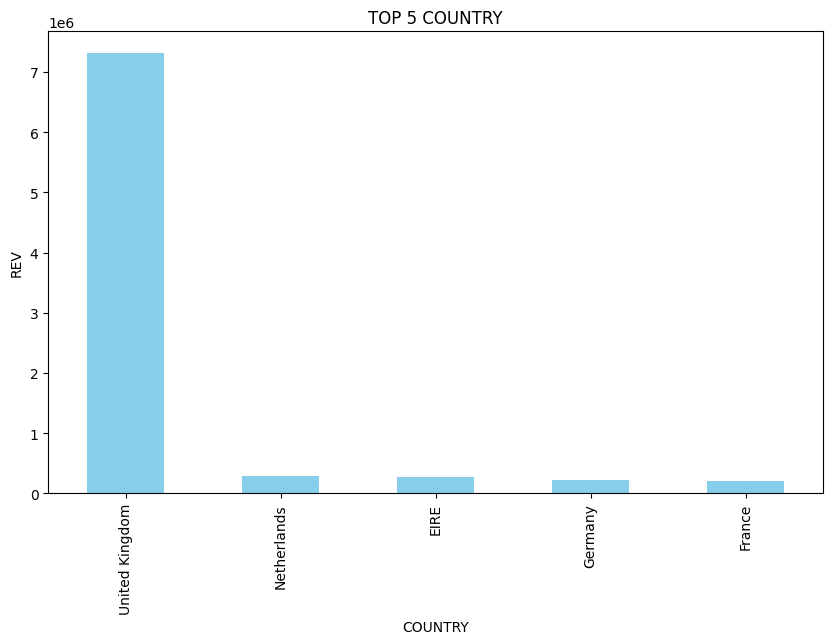

In [153]:
top_countries = df_retail.groupby('Country')['Total_Price'].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
top_countries.plot(kind='bar', color='skyblue')
plt.title('TOP 5 COUNTRY')
plt.xlabel('COUNTRY')
plt.ylabel('REV')
plt.show()

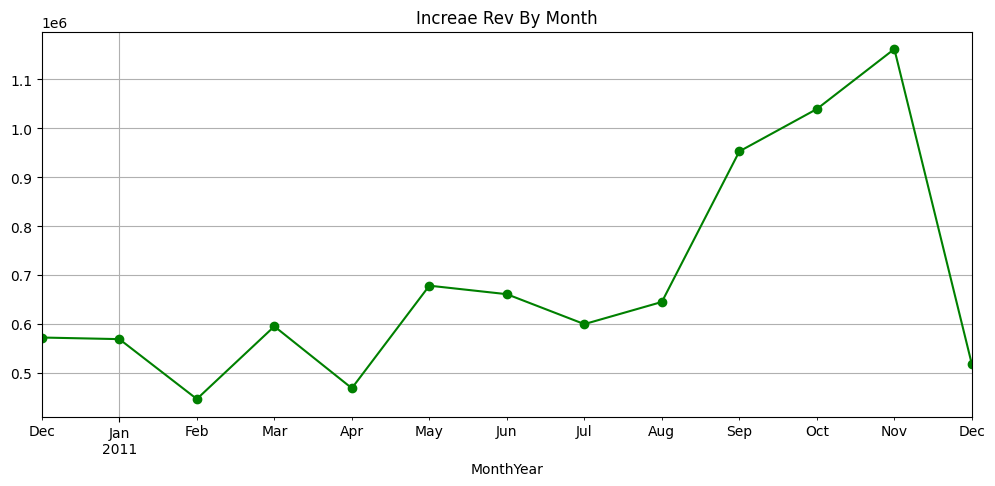

In [154]:
monthly_sales = df_retail.groupby('MonthYear')['Total_Price'].sum()
plt.figure(figsize=(12,5))
monthly_sales.plot(kind='line', marker='o', color='green')
plt.title('Increae Rev By Month')
plt.grid(True)
plt.show()

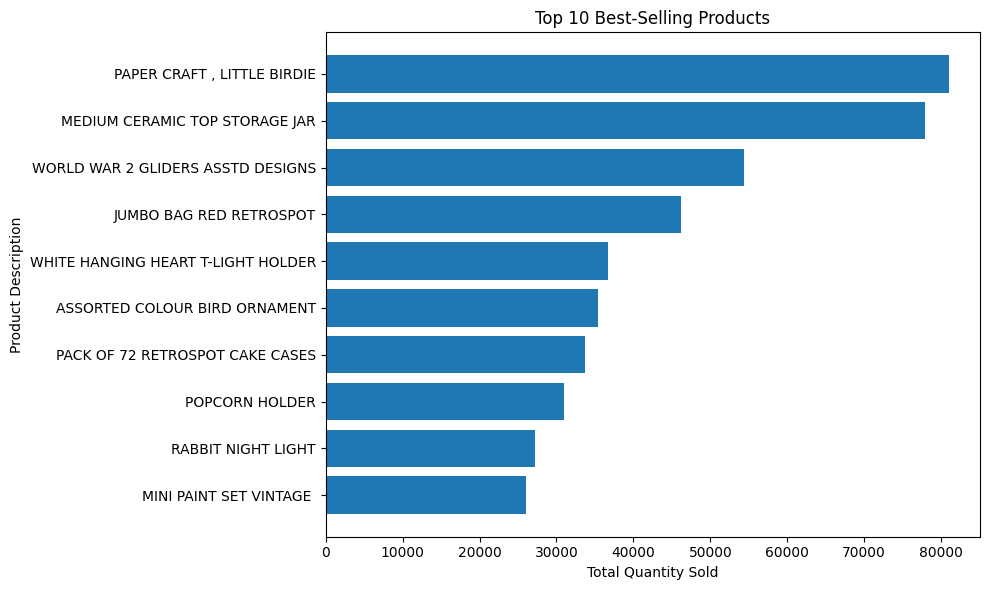

In [155]:
top_products = (
    df_retail
    .groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top_products.index, top_products.values)
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.title("Top 10 Best-Selling Products")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




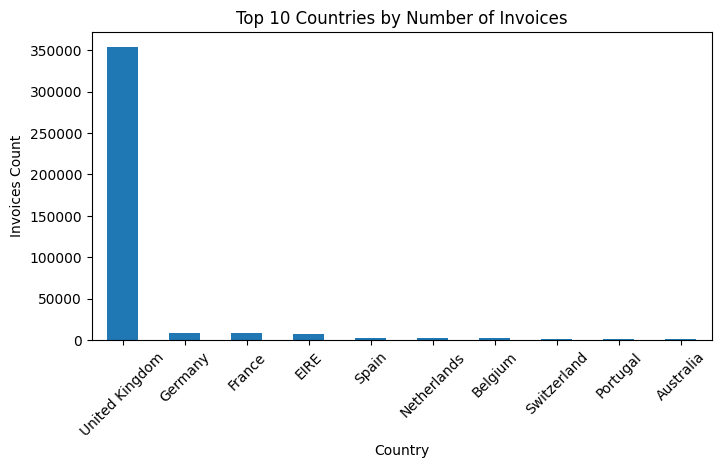

In [30]:
top_countries = df_retail['Country'].value_counts().head(10)

plt.figure(figsize=(8,4))
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Number of Invoices")
plt.ylabel("Invoices Count")
plt.xticks(rotation=45)
plt.show()






# **Spliting customers by RFM**

In [156]:
today_date = df_retail['InvoiceDate'].max() + dt.timedelta(days=1)

rfm_data = df_retail.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (today_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total_Price': 'sum'
})

rfm_data.columns = ['Recency', 'Frequency', 'Monetary']
rfm_data.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


try to do basket analysis

In [157]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

basket = (df_retail[df_retail['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# حذف عمود 'POSTAGE' لأنه مجرد مصاريف شحن وليس منتج حقيقي
if 'POSTAGE' in basket_sets.columns:
    basket_sets.drop('POSTAGE', inplace=True, axis=1)

print("Its ready lets go")

Its ready lets go


**Apriori**

In [158]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# ترتيب القواعد حسب قوة العلاقة (Lift)
rules = rules.sort_values('lift', ascending=False)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

                                          antecedents  \
3                         (ALARM CLOCK BAKELIKE RED )   
2                        (ALARM CLOCK BAKELIKE GREEN)   
5                         (ALARM CLOCK BAKELIKE PINK)   
4                         (ALARM CLOCK BAKELIKE RED )   
20  (SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...   
25                    (SET/6 RED SPOTTY PAPER PLATES)   
1                         (ALARM CLOCK BAKELIKE PINK)   
0                        (ALARM CLOCK BAKELIKE GREEN)   
24                      (SET/6 RED SPOTTY PAPER CUPS)   
21  (SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...   

                                          consequents   support  confidence  \
3                        (ALARM CLOCK BAKELIKE GREEN)  0.079692    0.837838   
2                         (ALARM CLOCK BAKELIKE RED )  0.079692    0.815789   
5                         (ALARM CLOCK BAKELIKE RED )  0.074550    0.725000   
4                         (ALARM CLOCK BAKELIKE PINK)  0

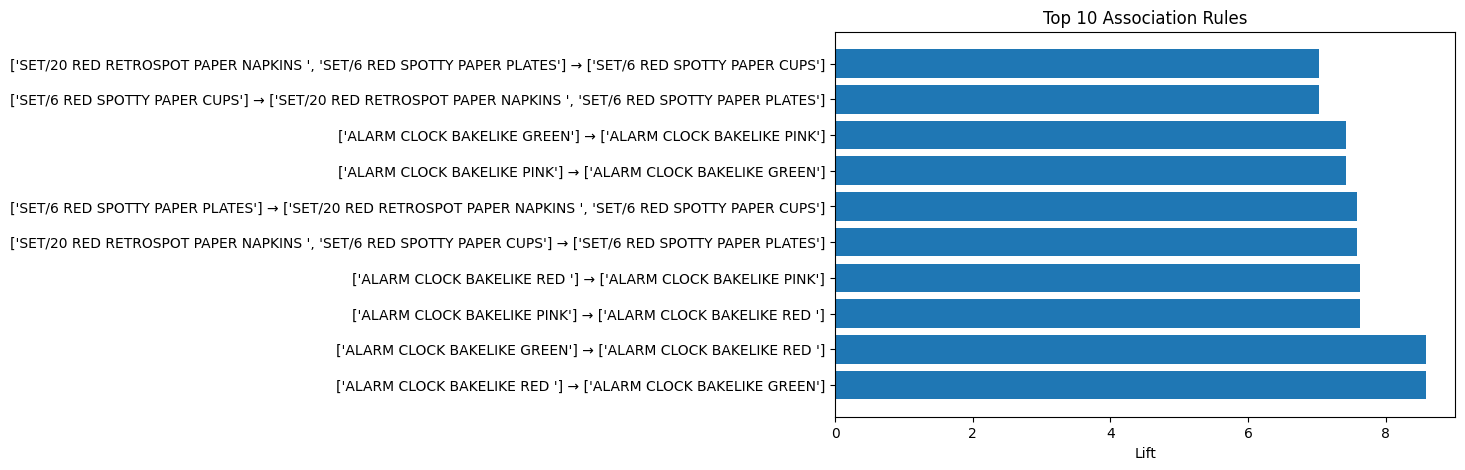

In [159]:
top_vis = rules.head(10)

plt.figure(figsize=(8,5))
plt.barh(range(len(top_vis)), top_vis['lift'])
plt.yticks(range(len(top_vis)),
           [f"{list(a)} → {list(c)}" for a, c in zip(top_vis['antecedents'], top_vis['consequents'])])
plt.xlabel("Lift")
plt.title("Top 10 Association Rules")
plt.show()


# **Recommend** to cus

In [160]:
top_rules = rules[ (rules['lift'] >= 4) & (rules['confidence'] >= 0.7) ]

print("أقوى التوصيات لترتيب المنتجات:")
for index, row in top_rules.iterrows():
    items_a = list(row['antecedents'])
    items_b = list(row['consequents'])
    print(f"if customer take a {items_a}، suggest him to buy {items_b}")

أقوى التوصيات لترتيب المنتجات:
if customer take a ['ALARM CLOCK BAKELIKE RED ']، suggest him to buy ['ALARM CLOCK BAKELIKE GREEN']
if customer take a ['ALARM CLOCK BAKELIKE GREEN']، suggest him to buy ['ALARM CLOCK BAKELIKE RED ']
if customer take a ['ALARM CLOCK BAKELIKE PINK']، suggest him to buy ['ALARM CLOCK BAKELIKE RED ']
if customer take a ['ALARM CLOCK BAKELIKE RED ']، suggest him to buy ['ALARM CLOCK BAKELIKE PINK']
if customer take a ['SET/20 RED RETROSPOT PAPER NAPKINS ', 'SET/6 RED SPOTTY PAPER CUPS']، suggest him to buy ['SET/6 RED SPOTTY PAPER PLATES']
if customer take a ['SET/6 RED SPOTTY PAPER PLATES']، suggest him to buy ['SET/20 RED RETROSPOT PAPER NAPKINS ', 'SET/6 RED SPOTTY PAPER CUPS']
if customer take a ['ALARM CLOCK BAKELIKE PINK']، suggest him to buy ['ALARM CLOCK BAKELIKE GREEN']
if customer take a ['ALARM CLOCK BAKELIKE GREEN']، suggest him to buy ['ALARM CLOCK BAKELIKE PINK']
if customer take a ['SET/6 RED SPOTTY PAPER CUPS']، suggest him to buy ['SET/20 RED